# Variational Quantum Classifier for Heart Disease Prediction

This notebook implements a Variational Quantum Classifier (VQC) to predict heart disease using the UCI Heart Disease dataset. The implementation follows a structured approach, including:

1. **Data Preprocessing**: Preparing the dataset for quantum processing.
2. **Quantum Circuit Design**: Defining the feature map and variational ansatz.
3. **Training**: Optimizing the variational parameters using gradient descent.
4. **Evaluation**: Assessing the model's performance on a test set.

The notebook adheres to modern Qiskit practices and provides clear explanations for each step.

---

## Prerequisites

### Installing Required Packages

To ensure all necessary libraries are available for this notebook, we use `pip` to install the required Python packages. 

This approach guarantees that the environment contains the latest versions of essential tools for quantum computing, data processing, and visualization.  
The `%pip` magic command is used within Jupyter notebooks to install packages directly from a notebook cell, making the setup process straightforward and reproducible.

In [ ]:
# Quantum Computing Framework
%pip install qiskit
%pip install qiskit-aer
%pip install qiskit-ibm-runtime
%pip install qiskit[visualization]

# Data Science and Machine Learning
%pip install scikit-learn
%pip install numpy
%pip install pandas

# Visualization and Plotting
%pip install matplotlib
%pip install matplotlib_inline

# Optimization
%pip install cma

### Importing the Packages

Following our installation of the packages, we need to import them to access the required methods and classes in our code. The imports are organized following Python conventions:

- **Standard libraries**: Core Python packages for data manipulation and visualization
- **Third-party and Scikit-learn libraries**: Specialized tools for optimization and machine learning
- **Qiskit libraries**: Quantum computing framework components

In [1]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Third-party optimization libraries
import cma
from scipy.optimize import minimize

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.utils import shuffle

# Qiskit imports
import qiskit
from qiskit import generate_preset_pass_manager
from qiskit.circuit.library import real_amplitudes, zz_feature_map
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

A small check to ensure everything is okay:

In [9]:
# Check if Qiskit is installed and print the version
if 'qiskit' in globals():
    print(f"Qiskit version: {qiskit.__version__}") # The version of Qiskit which we are currently using is 2.1.1. In the future, methods and classes may change
                                                   # or become deprecated, so it may be necessary to update the code accordingly.
else:
    print("Qiskit is not installed or not available in the current environment. Re-run the `Installing Required Packages` cell.")

Qiskit version: 2.1.1


---

## Constants

In [ ]:
QUBIT_COUNT = 4
RANDOM_STATE = 42
LEARNING_RATE = 1e-3
CLASS_LABELS = ['healthy', 'diseased']
TEST_SIZE = 0.3
SHOT_COUNT = 1024
CMA_ITER_COUNT = 250
COBYLA_ITER_COUNT = 60
HEART_DATA_PATH = 'heart_disease_uci.csv'
PRINT_COST = True


service = QiskitRuntimeService(name="freeya")

---

## Data Preparation

### Data Preprocessing for Binary Classification

This function loads the heart disease dataset, selects relevant features, and binarizes categorical variables to prepare the data for classification tasks.

#### Processing Details

* `cp` (chest pain type): encoded as 0 if asymptomatic, else 1
* `thal` (thalassemia): encoded as 0 if normal, else 1
* `num` (target): encoded as 0 for no disease, else 1

Only the following columns are retained:
`ca`, `cp`, `thal`, `oldpeak`, `num`

#### Output

Returns a cleaned DataFrame ready for modeling.

In [ ]:
def process_heart_disease_csv(path : str) -> pd.DataFrame:
    """
    Process the heart disease CSV file to select relevant features and binarize categorical columns.

    - 'cp' (chest pain type): 0 if 'asymptomatic', 1 otherwise.
    - 'thal': 0 if 'normal', 1 otherwise.
    - 'num': 0 if 0, 1 otherwise.

    Args:
        path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Processed DataFrame with only the relevant columns.
    """
    df = pd.read_csv(path)

    # Only keep relevant columns
    relevant_cols = ['ca', 'cp', 'thal', 'oldpeak', 'num']
    df = df[relevant_cols].copy()

    # Binarize 'cp': 0 if 'asymptomatic', 1 otherwise
    df['cp'] = df['cp'].apply(lambda x: 0 if str(x).strip().lower() == 'asymptomatic' or str(x).strip() == '0' else 1)

    # Binarize 'thal': 0 if 'normal', 1 otherwise
    df['thal'] = df['thal'].apply(lambda x: 0 if str(x).strip().lower() == 'normal' or str(x).strip() == '0' else 1)

    # Binarize 'num': 0 if 0, 1 otherwise
    df['num'] = df['num'].apply(lambda x: 0 if str(x).strip() == '0' else 1)

    # Convert all columns to float except 'num', 'ca' and 'oldpeak' (which are ints)
    for col in ['cp', 'thal']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.dropna().reset_index(drop=True)

    return df

### Data Normalization for Quantum Encoding

This function loads and normalizes heart disease dataset features and labels for use in quantum machine learning applications.

#### Source

Based on feature importance analysis in the paper:  
**[Explainable Artificial Intelligence Framework for Multimodal Data Analysis](https://www.nature.com/articles/s41598-022-24633-4)**  
The top 4 relevant features used are:
- `ca` (number of major vessels colored by fluoroscopy)  
- `cp` (chest pain type)  
- `thal` (thalassemia)  
- `oldpeak` (ST depression induced by exercise)

These are selected to match a 4-qubit quantum model.

#### Output

Returns the normalized training and test features and labels as a tuple.

In [ ]:
def normalize_data(path : str) -> tuple:
    """
    Load and normalize heart disease dataset features and labels.

    Based on feature importance analysis in:
    https://www.nature.com/articles/s41598-022-24633-4,
    we select the 4 most relevant features: 'ca', 'cp', 'thal', 'oldpeak'.

    Args:
        path (str): Path to the CSV file containing the heart disease dataset.
        
    Returns:
        tuple: Normalized (X_train, X_test) features and (Y_train, Y_test) labels.
    """
    # Load dataset and shuffle to randomize sample order
    df = process_heart_disease_csv(path)
    df = shuffle(df, random_state=RANDOM_STATE)

    # Select top 4 features for 4-qubit quantum encoding
    X = df[['ca', 'cp', 'thal', 'oldpeak']].values
    Y = df['num'].values

    # Split before scaling to avoid data leakage
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # Normalize inputs between 0 and π for angle encoding
    # The range (0, np.pi) is chosen to ensure that the angles used in quantum circuits are within a valid range for angle encoding.
    # This is important for quantum circuits that use angle encoding (e.g. Rx, Ry gates), as angles outside this range may
    # lead to incorrect results or inefficiencies in the quantum computation.
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, Y_train, Y_test

Obtaining the actual train and test data:

In [ ]:
X_train, X_test, Y_train, Y_test = normalize_data(HEART_DATA_PATH)

---

## Quantum Circuit Preparation

### Quantum Feature Map Initialization

Initializes a ZZFeatureMap circuit to encode classical input features into a quantum state for machine learning.

#### Configuration

* **Initial state**: All qubits set to $|0\rangle$
* **Feature map**: ZZFeatureMap with linear entanglement
* **Repetitions**: 2 layers for increased expressiveness
* **Qubit count**: Equals number of input features

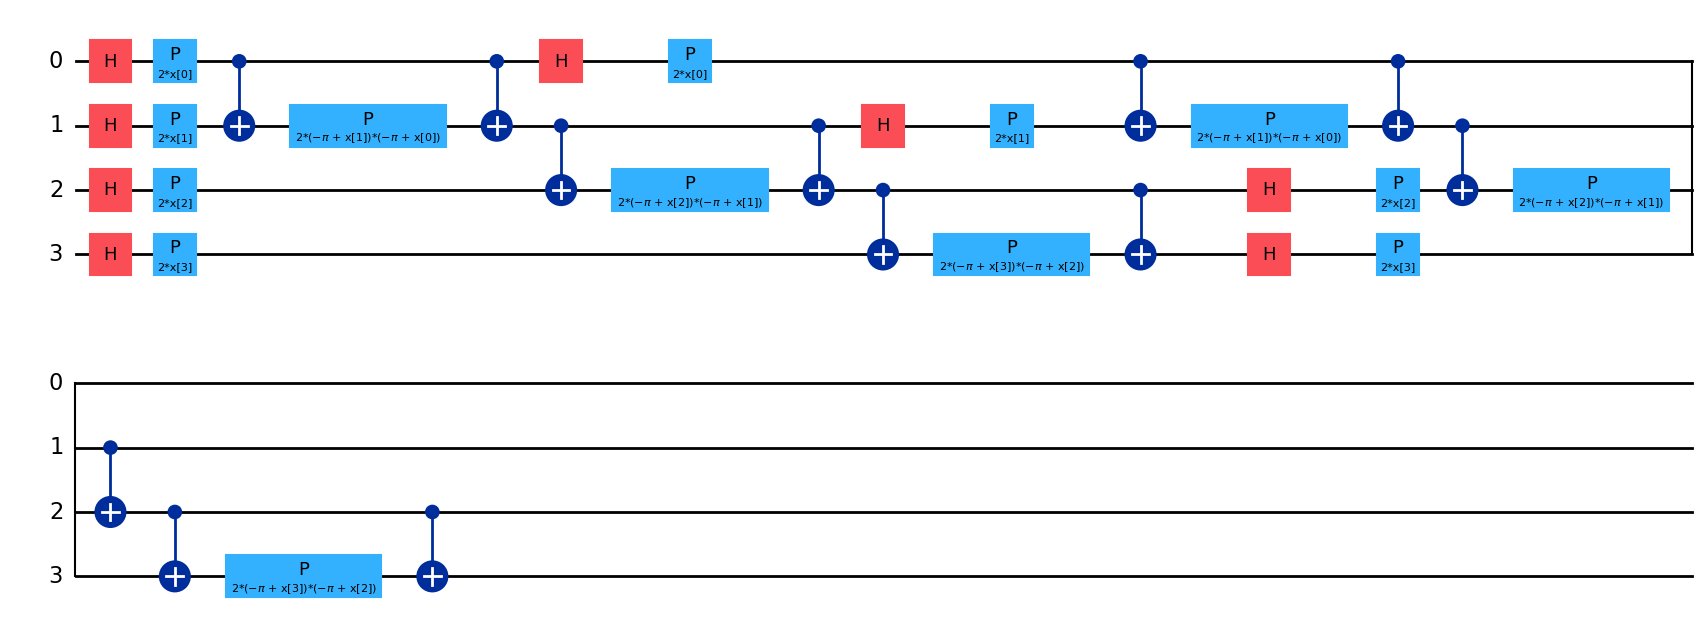

In [8]:
# Prepare the initial quantum state (all qubits in |0⟩ state)
state = Statevector.from_label('0' * QUBIT_COUNT)

# Create the ZZFeatureMap for encoding classical data into quantum states
feature_map = zz_feature_map(
    feature_dimension=QUBIT_COUNT, # Number of features/qubits
    reps=2,                        # Number of repetitions of the feature map circuit
    entanglement='linear'          # How qubits are entangled (linear = nearest neighbors)
)

# Visualize the feature map circuit
feature_map.draw(output='mpl')

### Ansatz Circuit Construction

Defines the parameterized quantum circuit (ansatz) used for learning in a variational quantum algorithm.

#### Configuration

* **Circuit type**: RealAmplitudes
* **Qubit count**: Matches the feature dimension
* **Entanglement**: Linear pattern
* **Repetitions**: 1 layer of parameterized gates

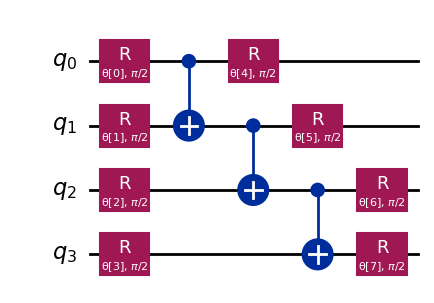

In [7]:
# Prepare the ansatz circuit used for parameterized learning
# This circuit will be optimized during training
ansatz = real_amplitudes(
    num_qubits=QUBIT_COUNT,  # Number of qubits = number of features
    reps=1,                  # One repetition layer of rotations + entanglement
    entanglement='linear'    # Linear entanglement between qubits
)

# Visualize the decomposed circuit
ansatz.decompose().draw(output='mpl')

### Quantum Circuit Composition

Combines the data-encoding feature map with the parameterized ansatz circuit.

#### Configuration

* **Feature Map**: Encodes classical features into quantum states
* **Ansatz**: Trainable circuit for learning patterns
* **Output Circuit**: Used for quantum machine learning models

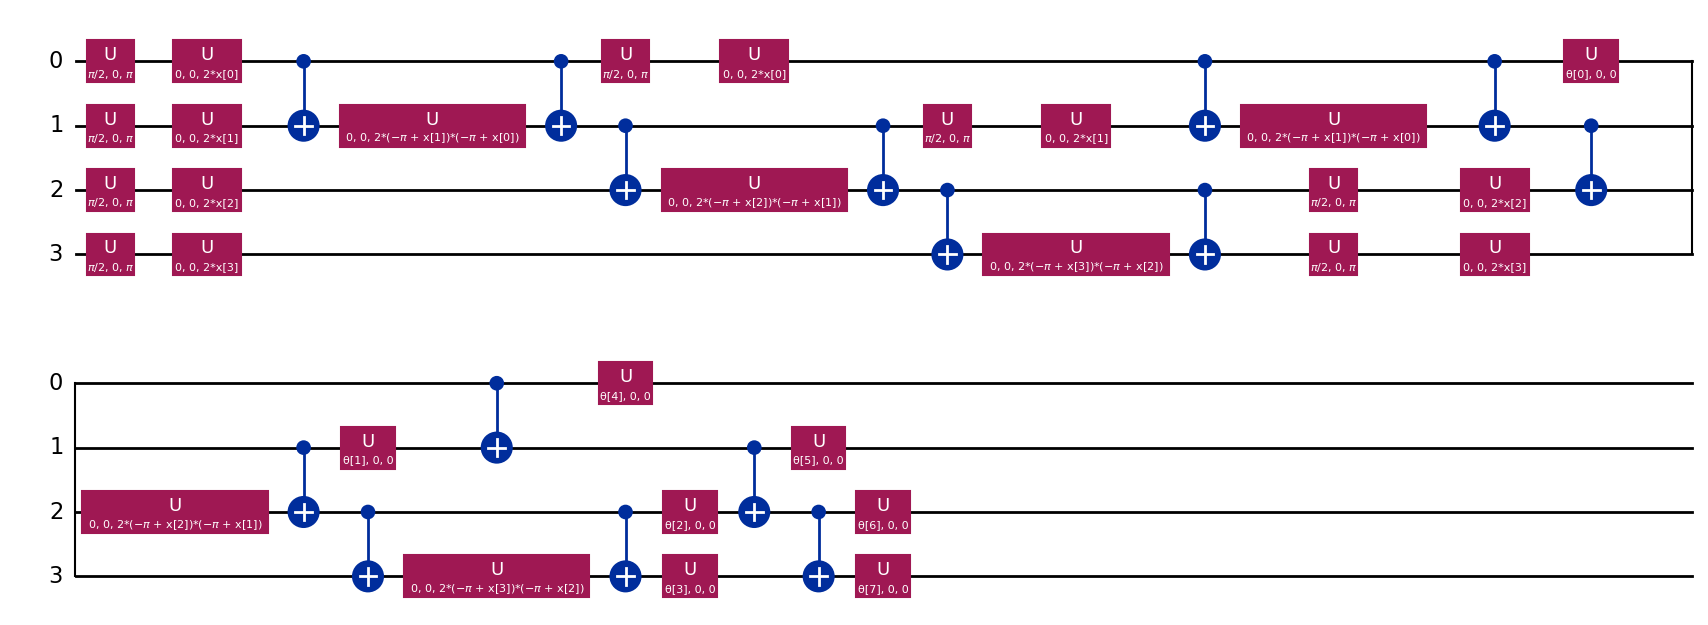

In [9]:
# Compose the full quantum circuit by combining feature map and ansatz
# The feature map encodes the input data; ansatz is the trainable part
circuit = feature_map.compose(ansatz, inplace=False)

# Visualize the decomposed circuit with multiple repetitions for clarity
circuit.decompose(reps=8).draw(output='mpl')

---

## Quantum Circuit Utility Functions

### Parameter Dictionary Creation for Quantum Circuit

This function creates a dictionary that maps parameters of both the feature map and ansatz circuits to their corresponding values.

#### Output

Returns a dictionary that associates each circuit parameter with its value, combining input features for the feature map and weights for the ansatz.  
Used to bind values before running the quantum circuit.

In [ ]:
def get_data_dict(params : list, x : list) -> dict:
    """
    Create a dictionary of parameters for the feature map and ansatz.

    Args:
        params (list): List of parameters for the ansatz (trainable weights).
        x (list): List of features for the feature map (input data).

    Returns:
        dict: A dictionary mapping circuit parameters to their corresponding values.
    """
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = x[i]  # Bind feature values to feature map parameters
    for i, p in enumerate(ansatz.parameters):
        parameters[p] = params[i]  # Bind trainable ansatz parameters
    return parameters

### Label Assignment Based on Bit String Parity

This function assigns a class label by calculating the parity of the Hamming weight (number of 1s) in a given bit string.

#### Processing Details

- Computes the Hamming weight of the bit string.
- Determines if the parity (sum of bits) is even or odd.
- Returns the first class label if parity is even, otherwise the second class label.

#### Output

Returns a class label based on the parity, useful for interpreting quantum measurement outcomes.

In [ ]:
def assign_label(bit_string : str, class_labels : list) -> str:
    """
    Assign a label based on the parity of the Hamming weight of the bit string.
    Args:
        bit_string (str): A string of bits representing the quantum state.
        class_labels (list): A list of class labels, e.g., ['yes', 'no'].
    Returns:
        str: The assigned class label based on the parity of the Hamming weight.
    """
    hamming_weight = sum([int(bit) for bit in list(bit_string)]) # Count the number of 1s in the bit string
    is_odd_parity = hamming_weight & 1 # Check if the Hamming weight is odd (1) or even (0)
    if is_odd_parity:
        return class_labels[1] # Return the second class label for odd parity
    else:
        return class_labels[0] # Return the first class label for even parity

### Probability Calculation from Quantum Measurement Counts

This function computes the probability of each class label based on measurement outcomes (bit string counts) from a quantum circuit.

#### Processing Details

* Takes the counts of measured bit strings from quantum circuit runs.
* Uses the `assign_label` function to classify each bit string based on parity.
* Aggregates probabilities by summing the relative frequencies of bit strings assigned to each class.

#### Output

Returns a dictionary mapping each class label to its probability, representing the likelihood of the quantum circuit outputting that class.

In [ ]:
def return_probabilities(counts : dict, class_labels : list) -> dict:
    """
    Calculate the probabilities of each class label based on the counts of bit strings.
    Args:
        counts (dict): A dictionary containing the counts of bit strings.
        class_labels (list): A list of class labels, e.g., ['yes', 'no'].
    Returns:
        dict: A dictionary with class labels as keys and their probabilities as values.
    """
    shots = sum(counts.values()) # Total number of shots (measurements)
    result = {class_labels[0]: 0, class_labels[1]: 0} # Initialize result dictionary with class labels
    for key in counts:
        label = assign_label(key, class_labels) # Assign label based on parity of the bit string
        result[label] += counts[key] / shots # Normalize counts to probabilities
    return result

---

## Quantum Classification and Cost Functions

### Quantum Circuit Classification

This function classifies multiple input feature vectors by running parameterized quantum circuits on a simulator or quantum backend.

#### Processing Details

* For each input feature vector:

  * Binds feature data and ansatz parameters to the quantum circuit.
  * Adds measurement operations to read out qubit states.
  * Transpiles/prepares the circuit for execution.
* Runs all circuits in batch on the quantum sampler.
* Converts measurement results into class probabilities using parity-based labeling.

#### Output

Returns a list of dictionaries, each containing class labels and their associated probabilities for the corresponding input feature vector.

In [ ]:
def classify(x_list : list, params : list, sampler : any, pm : any) -> list:
    """
    Classify a list of feature vectors using the quantum circuit.

    Args:
        x_list (list): A list of feature vectors to classify.
        params (list): A list of parameters for the ansatz.
        sampler: Quantum sampler backend to run the circuits. Either a simulator or a real quantum backend.
        pm: Quantum processor manager or transpiler to prepare circuits.

    Returns:
        list of dict: Each dict contains class labels as keys and their probabilities as values.
    """
    qc_list = []

    for x in x_list:
        # Bind input features and ansatz parameters to the circuit
        classifier = circuit.assign_parameters(get_data_dict(params, x))
        # Add measurement operations on all qubits
        classifier.measure_all()

        # Transpile or prepare the circuit for the backend
        transpiled_circuit = pm.run(classifier)
        qc_list.append(transpiled_circuit)

    # Execute all circuits on the simulator or quantum backend
    results = sampler.run(qc_list, shots=SHOT_COUNT).result()
    probs = []

    for qc in results:
        # Extract counts of measurement outcomes
        counts = qc.data.meas.get_counts()
        # Convert counts to probabilities for each class label
        prob = return_probabilities(counts, CLASS_LABELS)
        probs.append(prob)

    return probs

### Cost Functions

#### Binary Cross-Entropy Cost

This function calculates the Binary Cross-Entropy (BCE) loss for a predicted probability corresponding to the expected class label.

##### Output

Returns the BCE loss, a measure of how well the predicted probability matches the expected class (lower is better).

In [ ]:
def binary_cross_entropy(probs : dict, expected_label : str) -> float:
    """
    Calculate the Binary Cross-Entropy (BCE) cost function.

    Args:
        probs (dict): Predicted probabilities keyed by class labels (strings).
        expected_label (str): The true class label.

    Returns:
        float: Binary Cross-Entropy loss value.
    """
    eps = 1e-10  # Small value to avoid log(0) errors

    # Get predicted probability for the expected label, clipped for numerical stability
    p = probs.get(expected_label, 0.0)
    p = np.clip(p, eps, 1 - eps)

    # Compute BCE loss
    return -np.log(p)

#### Cost Function for Quantum Circuit Training

Calculates the average loss over the dataset by comparing predicted probabilities against expected labels using Binary Cross-Entropy.

##### Output

Returns the average cost (loss), which guides optimization of the quantum circuit parameters.

In [ ]:
def cost_function(X : list, Y : list, params : list, cost_list : list) -> float:
    """
    Calculate the average cost over the dataset using given parameters.

    Args:
        X (list): Feature vectors to classify.
        Y (list): Corresponding labels (0 or 1).
        params (list): Parameters for the ansatz circuit.
        cost_list (list): List to store the computed cost values.

    Returns:
        float: Average cost over all samples.
    """
    cost = 0
    training_labels = []
    training_samples = []

    # Prepare samples and convert labels to string class labels
    for sample in X:
        training_samples.append(sample)
    for label in Y:
        if label == 0:
            training_labels.append(CLASS_LABELS[0])
        elif label == 1:
            training_labels.append(CLASS_LABELS[1])

    # Classify samples using the current parameters
    probs = classify(training_samples, params, CLASS_LABELS, SHOT_COUNT)

    # Calculate binary cross-entropy cost for each sample and sum
    for i, prob in enumerate(probs):
        cost += binary_cross_entropy(prob, training_labels[i])

    # Average cost over all samples
    cost /= len(training_samples)

    # Optionally print the cost, if enabled
    if PRINT_COST:
        print(f'{cost:.4f}')

    # Store cost value for tracking
    cost_list.append(cost)
    return cost

---

In [ ]:
# Create a simulator backend
backend = service.backend("ibm_aachen")
aer_sim = AerSimulator().from_backend(backend)
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
sampler = Sampler(mode=aer_sim)


transpiled_circuit = pm.run(circuit)
print('Depth of two-qubit gates: ', transpiled_circuit.depth(lambda x: len(x.qubits) == 2))
transpiled_circuit.draw(output="mpl", idle_wires=False, fold=40)

In [ ]:


cost_list = []

# Define the initial parameters for the ansatz
#np.random.seed(RANDOM_STATE)
init_params = 2*np.pi*np.random.rand(QUBIT_COUNT*2*2)

# Define objective function
objective_function = lambda params: cost_function(X_train, Y_train, params, cost_list)

# Optimize the parameters using the COBYLA optimizer
result = cma.fmin2(objective_function, sigma0=0.1,x0=init_params, options = {'maxfevals': CMA_ITER_COUNT,}, noise_handler=cma.NoiseHandler(QUBIT_COUNT*2*2))

# Print the optimized parameters and the final cost value
print(result)

In [ ]:
result[1].best.x, result[1].best.f

In [ ]:
fig = plt.figure()
plt.plot(range(len(cost_list)), cost_list)
plt.xlabel('Steps')
plt.ylabel('Cost value')
plt.title("COBYLA BCE Cost value against steps")
plt.show()

In [ ]:
def test_model(X, Y, params, sampler, pm):
    accuracy = 0
    training_samples = []
    for sample in X:
        training_samples += [sample]
    probs = classify(training_samples, params, sampler, pm, shots=1024)
    for i, prob in enumerate(probs):
        if (prob.get('yes') >= prob.get('no')) and (Y[i] == 0):
            accuracy += 1
        elif (prob.get('no') >= prob.get('yes')) and (Y[i] == 1):
            accuracy += 1
    accuracy /= len(Y_test)
    print("Test accuracy: {}\n".format(accuracy))
    return accuracy


In [ ]:
total = 0
iter = 30
for i in range (iter):
    total += test_model(X_test, Y_test, result[1].best.x, sampler, pm)
print(f"Average Test Accuracy over {iter} iterations: {total / iter}")
